In [1]:
import numpy as np
rng = np.random.default_rng()

In [2]:
import pickle

# Read list to memory
def read_list(list_name):
    # for reading also binary mode is important
    with open(list_name, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

In [3]:
data = np.load('train_prediction.npy')
query_set= np.load('test_prediction.npy')
train_images = np.load('trainset.npy')
train_labels = read_list('train_labels')
test_images = np.load('testset.npy')
test_labels = read_list('test_labels')

## Main LSH Class

In [4]:

def normalise_data(data):
    return data/np.linalg.norm(data,axis=1,keepdims=True)

class LSH:
    def __init__(self, data, k, L):
        """
        Initialize LSH object.

        :param data: Input data of size (n,d) (numpy array).
        :param k: Number of hash functions per hash table.
        :param L: Number of hash tables.
        """
        self.data = normalise_data(data)
        self.k = k
        self.d = data.shape[1]
        self.L = L
        self.pivot = self.generate_pivot()
        self.hash_values = self.build_index()


    def generate_pivot(self):

        pivot = np.random.randn(self.L , self.d)
        pivot = pivot.astype(np.float16)
        pivot = pivot/np.linalg.norm(pivot,axis=1,keepdims=True)
        return pivot

    def build_index(self):
        """
        Build index.
        """
        # print(self.data.dtype)
        self.data = self.data.astype(np.float16)
        result = self.data @ self.pivot.T
        result=np.floor(result*(self.k-1) + self.k)
        result = result.astype(np.uint16)
        return result


    def query(self, query):
        """
        Query LSH index.

        :param query_vec: Query vector (numpy array).
        :return: List of similar vectors (numpy arrays).
        """
    
        query_vec=query/np.linalg.norm(query)
        query_vec = query_vec.astype(np.float16)
        query_results = self.pivot @ query_vec
        query_results=np.floor(query_results*(self.k-1) + self.k)
        search_set=np.array([], dtype=np.uint16)
        
        for i in range(self.L):
            query_result=query_results[i]
            vec = self.hash_values[:,i]
            search_set = np.union1d(search_set,np.where(vec==query_result)[0])
        return search_set
    
    def print(self):
        print(self.hash_values.shape)
        # print(self.hash_values[:, 0])
        print(self.hash_values.max())
        print(self.hash_values.min())


### To estimate TOPK elements using LSH

In [5]:
def estimated_topk(k, lsh):

    norm_data = normalise_data(data)
    sz = query_set.shape[0]
    top_k_q = np.empty((sz, k), dtype = np.uint32)
    
    for i in range(sz):

        query_pt = query_set[i].reshape(-1,1)
        result= lsh.query(query_pt)
        
        query = query_pt/ np.linalg.norm(query_pt)

        data_bin = norm_data[result]

        neighbours = data_bin @ query
        indexed_neighbours = np.concatenate((neighbours, result.reshape(-1,1)) ,axis=1)

        sorted_neighbours =  indexed_neighbours[indexed_neighbours[:, 0].argsort()]
        # print(sorted_neighbours)

        top_k = sorted_neighbours[-k:,: ]
        top_k = top_k[:, 1].astype(np.uint32)
        top_k = np.flip(top_k, 0)
        if (top_k.size < 5):
            top_mk = np.zeros(5)
            top_mk[0: top_k.size] = top_k
        else:
            top_mk = top_k
        top_k_q[i] = top_mk
        # print(top_k)

    return top_k_q


### Actual TOPK elements using linear algo

In [6]:
def actual_topk(k):

    norm_data = normalise_data(data)
    sz = query_set.shape[0]
    top_k_a = np.empty((sz, k), dtype = np.uint32)
    
    for i in range(sz):

        query_pt = query_set[i].reshape(-1,1)
        query = query_pt/ np.linalg.norm(query_pt)

        neighbours = norm_data @ query
        indices = np.arange(data.shape[0]).reshape(-1,1)
        indexed_neighbours = np.concatenate((neighbours, indices) ,axis=1)

        sorted_neighbours =  indexed_neighbours[indexed_neighbours[:, 0].argsort()]

        top_k = sorted_neighbours[-k:,: ]
        top_k = top_k[:, 1].astype(np.uint32)
        top_k_a[i] = np.flip(top_k, 0)

    return top_k_a


### Calculation of Accuracy, Recall

In [7]:
def calculate_accuracy(a_topk, e_topk):
    sz = query_set.shape[0]
    actual = 0
    estimated = 0
    for i in range(sz):
        query_label = test_labels[i]
        for j in range(5):
            if query_label == train_labels[a_topk[i,j]]:
                actual += 1
            if query_label == train_labels[e_topk[i,j]]:
                estimated += 1 


    accuracy = estimated/ (2*actual - estimated) * 100
    recall = estimated/ (actual) * 100

    print(f'Accurracy = {accuracy:.2f}%')
    print(f'Recall = {recall:.2f}%')

    return accuracy, recall


### Plots Time vs K, Time vs L , Accuracy vs K , Accuracy vs L , Construction time vs K, Construction vs L, Accuracy/Time vs K/L


In [8]:
import time

In [9]:
sz  = data.shape[0]
K = [int(sz/30), sz/20, sz/15, sz/10, sz/5]
L = [3, 5, 10, 15, 20]

In [10]:
start_time = time.time()
a_topk = actual_topk(5)
end_time = time.time() - start_time

actual_time = end_time

actual_time  = np.full(5, end_time)

In [11]:
time_const_k = []
accuracy_k = []
recall_k = []
query_time_k = []

for k in range(len(K)):
    l = 10
    start_time = time.time()
    lsh = LSH(data, K[k], l)
    end_time = time.time() - start_time
    time_const_k.append(end_time) 

    start_time = time.time()
    e_topk = estimated_topk(5, lsh)
    end_time = time.time() - start_time
    query_time_k.append(end_time)

    acc, recall = calculate_accuracy(a_topk, e_topk)
    accuracy_k.append(acc)
    recall_k.append(recall)


time_const_l = []
accuracy_l = []
recall_l = []
query_time_l = []

for l in range(len(L)):
    k = sz/20
    start_time = time.time()
    lsh = LSH(data, k, L[l])
    end_time = time.time() - start_time
    time_const_l.append(end_time) 

    start_time = time.time()
    e_topk = estimated_topk(5, lsh)
    end_time = time.time() - start_time
    query_time_l.append(end_time)

    acc, recall = calculate_accuracy(a_topk, e_topk)
    accuracy_l.append(acc)
    recall_l.append(recall)    



Accurracy = 82.35%
Recall = 90.32%
Accurracy = 90.14%
Recall = 94.82%
Accurracy = 87.97%
Recall = 93.60%
Accurracy = 90.37%
Recall = 94.94%
Accurracy = 90.42%
Recall = 94.97%
Accurracy = 77.10%
Recall = 87.07%
Accurracy = 83.94%
Recall = 91.27%
Accurracy = 90.61%
Recall = 95.07%
Accurracy = 92.32%
Recall = 96.01%
Accurracy = 94.17%
Recall = 97.00%


In [12]:
accuracy_k = np.array(accuracy_k)
query_time_k = np.array(query_time_k)
accuracy_l = np.array(accuracy_l)
query_time_l = np.array(query_time_l)

time_by_acc_k = query_time_k/accuracy_k
time_by_acc_l = query_time_l/accuracy_l

time_by_acc_true = actual_time/100.0

## Plotting various plots

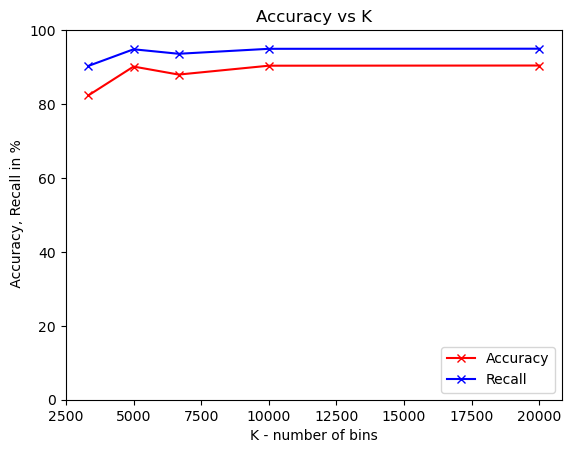

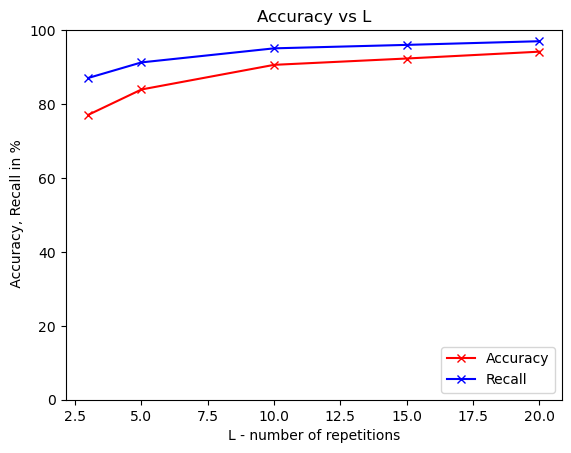

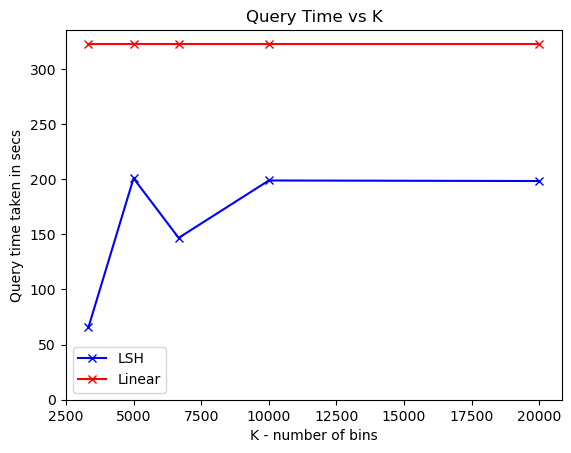

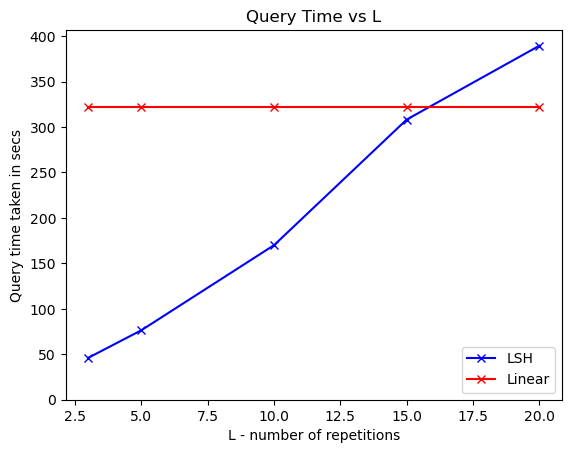

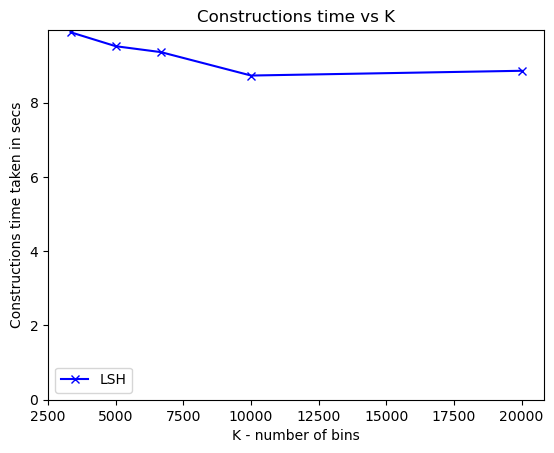

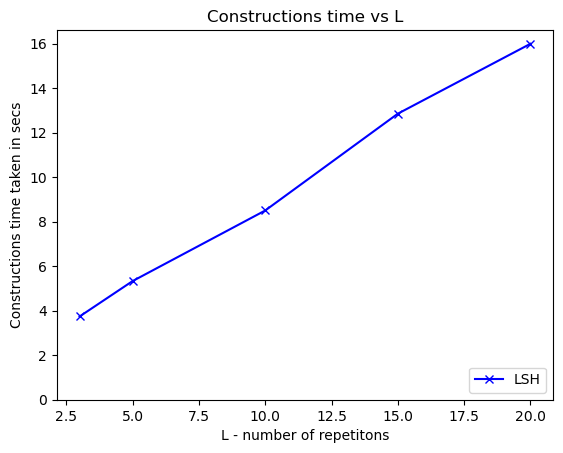

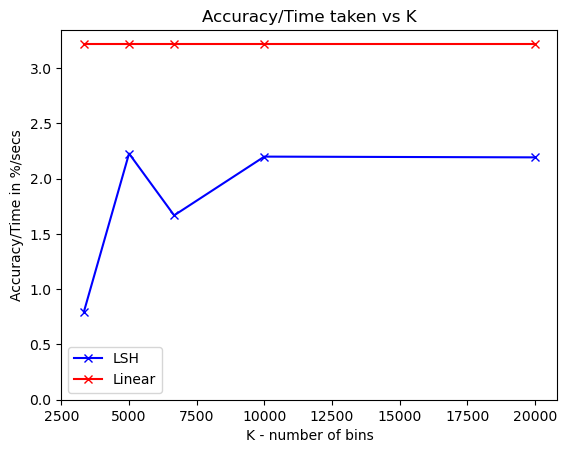

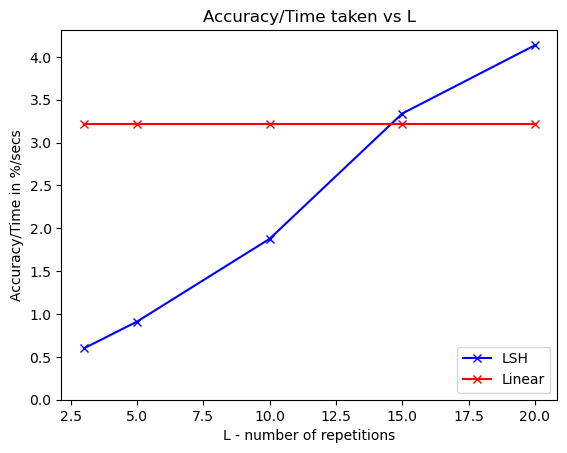

In [13]:

import matplotlib.pyplot as plt

plt.plot(K, accuracy_k, c = 'r', label = "Accuracy", marker = 'x')
plt.plot(K, recall_k, c = 'b', label = "Recall", marker = 'x')
plt.xlabel('K - number of bins')
plt.ylabel(' Accuracy, Recall in %')
plt.ylim(0,100)
plt.title('Accuracy vs K')
plt.legend(loc = 4)
plt.savefig('fig1.png')
plt.show()


plt.plot(L, accuracy_l, c = 'r', label = "Accuracy", marker = 'x')
plt.plot(L, recall_l, c = 'b', label = "Recall", marker = 'x')
plt.xlabel('L - number of repetitions')
plt.ylabel(' Accuracy, Recall in %')
plt.ylim(0, 100)
plt.title('Accuracy vs L')
plt.legend(loc= 4)
plt.savefig('fig2.png')
plt.show()


plt.plot(K, query_time_k, c = 'b', label = 'LSH', marker = 'x')
plt.plot(K, actual_time, c= 'r' , label = 'Linear', marker = 'x')
plt.xlabel('K - number of bins')
plt.ylabel('Query time taken in secs')
plt.ylim(bottom = 0)
plt.title('Query Time vs K')
plt.legend(loc= 3)
plt.savefig('fig3.png')
plt.show()

plt.plot(L, query_time_l, c = 'b', label = 'LSH', marker = 'x')
plt.plot(L, actual_time, c= 'r' , label = 'Linear', marker = 'x')
plt.xlabel('L - number of repetitions')
plt.ylabel('Query time taken in secs')
plt.ylim(bottom = 0)
plt.title('Query Time vs L')
plt.legend(loc= 4)
plt.savefig('fig4.png')
plt.show()

plt.plot(K , time_const_k , c = 'b', label = 'LSH', marker = 'x')
plt.xlabel('K - number of bins')
plt.ylabel('Constructions time taken in secs')
plt.title('Constructions time vs K')
plt.legend(loc= 3)
plt.ylim(bottom = 0)
plt.savefig('fig5.png')
plt.show()

plt.plot(L , time_const_l , c = 'b', label = 'LSH', marker = 'x')
plt.xlabel('L - number of repetitons')
plt.ylabel('Constructions time taken in secs')
plt.title('Constructions time vs L')
plt.legend(loc= 4)
plt.ylim(bottom = 0)
plt.savefig('fig6.png')
plt.show()

plt.plot(K , time_by_acc_k , c = 'b', label = 'LSH', marker = 'x')
plt.plot(K,  time_by_acc_true, c= 'r' , label = 'Linear', marker = 'x')
plt.xlabel('K - number of bins')
plt.ylabel('Time/Accuracy in %/secs')
plt.title('Time/Accuracy taken vs K')
plt.legend(loc= 3)
plt.ylim(bottom = 0)
plt.savefig('fig7.png')
plt.show()

plt.plot(L , time_by_acc_l , c = 'b', label = 'LSH', marker = 'x')
plt.plot(L,  time_by_acc_true, c= 'r' , label = 'Linear', marker = 'x')
plt.xlabel('L - number of repetitions')
plt.ylabel('Time/Accuracy in %/secs')
plt.title('Time/Accuracy taken vs L')
plt.legend(loc= 4)
plt.ylim(bottom = 0)
plt.savefig('fig8.png')
plt.show()

In [14]:
lsh = LSH(data, sz/20, 10)
e_topk = estimated_topk(5, lsh)

### Printing some images for K , L

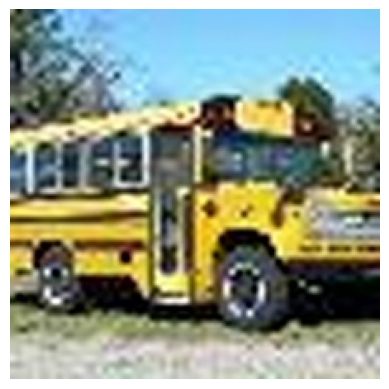

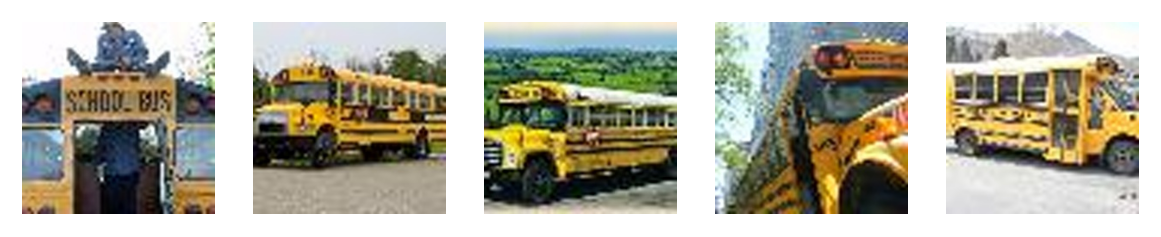

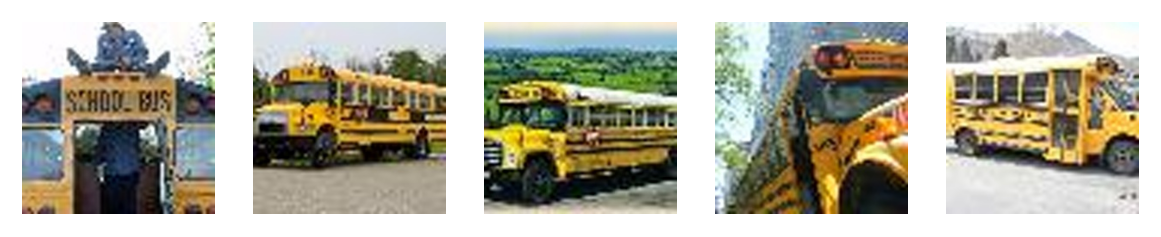

In [29]:
for j in range(1):
    img_ind = rng.integers(low=0, high= query_set.shape[0], size=10)
    plt.imshow(test_images[img_ind[j]])
    plt.axis('off')
    plt.show()

    f, axarr = plt.subplots(1, 5)
    f.dpi = 225

    for i in range(5):

        # axarr[i].set_title(f'{train_labels[e_topk[img_ind,i]]}', fontsize= 6)
        axarr[i].axis("off")
        axarr[i].imshow(train_images[e_topk[img_ind[j],i]])

    f, axarr = plt.subplots(1, 5)
    f.dpi = 225

    for i in range(5):

        # axarr[i].set_title(f'{train_labels[a_topk[img_ind,i]]}', fontsize=6)
        axarr[i].axis("off")
        axarr[i].imshow(train_images[a_topk[img_ind[j],i]])

